In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from IPython.display import display, clear_output
from scipy.optimize import fsolve, least_squares
from scipy.integrate import odeint, quad
from time import perf_counter
from scipy.interpolate import RectBivariateSpline
import pandas as pd
from numba import njit
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


Bad key text.latex.preview in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\mcdon\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [22]:
##Currently, using this code for electric simulations causes problems, but I have a different code for that. 
##I should clean this up to get rid of the parts that are broken. 
##Future work: MHE, deltaU, variable prediction steps

##Parameters

folder = "MultiparticleComb" #folder to save to

#simulation parameters
ntimes = 601      #number of simulation time steps
tend = 300        #end time in seconds
length = 0.0002   #domain length in meters. 
nprobes = 20      #number of probes. Must be multiple of 4
nelectrodes = 0   #number of electrodes
boundaryscale = 3 #number of domain lengths extended for finite difference. 3 is one domain and another on each side
dt = 0.002        #timestep for physics

#target function parameters
v0 = 1E-6                               #loiter velocity, m/s
xt = length/2                           #center of the circle
yt = length/2
rd = 3.0E-5                             #desired loiter distance, m
pos = np.array([[xt+rd,yt],[xt,yt+rd],[xt-rd,yt],[xt,yt-rd]]) #initial positions of particles
nparticles = len(pos)                   #number of particles

#physical parameters
mu = 2.0E-10/1000                    #diffusiophoretic mobility of particle m^2/M s. Divide by 1000 to turn Liters to meters^3.
mue = 2.0E-8                         #electrophoretic mobility of particles in Coulomb/Newton * m/s or m^2/V s 
epsilon = 78.4*8.8542E-12            #Dielectric constant of water in C^2/Nm^2 
D = 2.30E-9                          #diffusion coefficient of solute. This number is the self-diffusion coeff of water at 25 C.
Brown = 1                            #Brownian motion. Set to 1 for on or 0 for off
T = 298                              #Temperature in K
kb = 1.38064852E-23                  #Boltzmann's constant
viscosity = 8.9E-4                   #viscosity of water
radius = 3E-6                        #m, radius of colloidal particle
Dp = kb*T/(viscosity*6*np.pi*radius) #diffusion coefficient of colloidal particle

#controller parameters
nvision = 5         #prediction horizon
W1 = 20             #weight for residuals in objective function
Wdelta = 1          #weight for deltau in objective function
cutoffpercent = 0.2 #higher value will solve faster but be less accurate.
feedbackgain = 1.0  #gain for target function
ubfactor = 5        #multiple of umax to set upper bound at. 1 is normal for a single particle.
ubefactor = 5       #multiple of uemax to set upper bound at. 1 is normal for a single particle.

#MHE parameters. MHE is currently broken
npast = 10          #number of past points to use for MHE #change to 20 after testing is done
muguess = mu        #guess values for MHE
Dguess = D 
Werror = 100        #weights for MHE
Wmu = 1

##Initialize arrays and define variables

#Find the locations of the evenly spaced probes
def setprobes(nprobes):
    x0 = np.zeros((nprobes,2))         #array for positions of chemical probes
    spacing = length/(nprobes/4 + 1)   
    count0,count1,count2,count3 = (0,0,0,0)
    for i in range(nprobes):           #space the probes evenly along each of the four sides
        if i%4 == 0: #left side
            x0[i,0]+= 0
            count0 += spacing
            x0[i,1]+= count0
        if i%4 == 1: #right side
            x0[i,0] += length
            count1 += spacing
            x0[i,1]+= count1
        if i%4 == 2: #bottom
            x0[i,1]+= 0
            count2 += spacing
            x0[i,0]+=count2       
        if i%4 == 3: #top
            x0[i,1]+= length
            count3 += spacing
            x0[i,0]+= count3
    return x0
x0  = setprobes(nprobes)
x0e = setprobes(nelectrodes)


#some more setup stuff, generally don't change this
t = np.linspace(0.0,tend,ntimes) #time of simulation in seconds 
delta_t = t[1] - t[0]
tsteps = t.copy() + 0.0000001    #array for decision times. 0.0000001 lets us avoid dividing by zero. 
        
if nprobes != 0:
    mode = "chemical"
elif nelectrodes != 0:
    mode = "electric"
else:
    raise #both together is not ready yet
    
umax = 2*np.pi*D*length*v0/np.abs(mu)         #characteristic scale for chemical reaction
uemax = 2*np.pi*epsilon*length*v0/np.abs(mue) #characteristic scale for electric charge
ub  = ubfactor*umax      #upper bound for chemical reactions
ube = ubefactor*uemax    #upper bound for electrode charge (or voltage? which one?) 
if mode == "chemical":
    bnds = ((-ub,ub))
    mhebnds = ([1.0E-10/1000,1.00E-9],[5.0E-10/1000,3.00E-9]) #move these so they can be part of controller tuning
elif mode == "electric":
    bnds = ((-ube,ube))
    mhebnds = ((0,mue)) #fix this

Lxy = boundaryscale*length    # simulation length
nxy     = 50*boundaryscale+1  # number of grid points in x and y directions
tFac    = 0.5                 # stability factor. Must be 0.5 or less
tau     = Lxy**2/D            # diffusive timescale based on the whole domain.
deltaxy = Lxy/(nxy-1)         # grid spacing in x and y directions
dtwant = tFac*deltaxy**2/D  # desired timestep size
if dt > dtwant:               #make sure to set this so that dt is a nice number smaller than dtwant
    print(dtwant)
    raise
dtratio = int(delta_t/dt)
print(dtwant)


###Functions

##target

@njit #desired trajectory
def targetpos(t):
    x = np.zeros(nparticles)
    y = np.zeros(nparticles)
    x[0] = xt+rd*np.cos(v0*t/rd)
    y[0] = yt+rd*np.sin(v0*t/rd)
    x[1] = xt+rd*np.cos(v0*t/rd+np.pi/2)
    y[1] = yt+rd*np.sin(v0*t/rd+np.pi/2)
    x[2] = xt+rd*np.cos(v0*t/rd+np.pi)
    y[2] = yt+rd*np.sin(v0*t/rd+np.pi)
    x[3] = xt+rd*np.cos(v0*t/rd+3/2*np.pi)
    y[3] = yt+rd*np.sin(v0*t/rd+3/2*np.pi)
    return np.vstack((x,y))

@njit #velocity target (derivative of desired trajectory with a feedback correction)
def targetfeedback(xs,t,xyought):
    k = feedbackgain
    x = xs[0]
    y = xs[1]
    xought = xyought[0]
    yought = xyought[1]
    dx = np.zeros(nparticles)
    dy = np.zeros(nparticles)
    dx[0] = -v0*np.sin(v0*t/rd)-k*(x[0]-xought[0])
    dy[0] = v0*np.cos(v0*t/rd) -k*(y[0]-yought[0])
    dx[1] = -v0*np.sin(v0*t/rd+np.pi/2)-k*(x[1]-xought[1])
    dy[1] = v0*np.cos(v0*t/rd+np.pi/2) -k*(y[1]-yought[1])
    dx[2] = -v0*np.sin(v0*t/rd+np.pi)-k*(x[2]-xought[2])
    dy[2] = v0*np.cos(v0*t/rd+np.pi) -k*(y[2]-yought[2])
    dx[3] = -v0*np.sin(v0*t/rd+3/2*np.pi)-k*(x[3]-xought[3])
    dy[3] = v0*np.cos(v0*t/rd+3/2*np.pi) -k*(y[3]-yought[3])
    return np.vstack((dx,dy))


##model

@njit #chemical kernel for a single step function
def f(t,tn,x,x0,y,y0,u_i,mu, D): 
    if t>tn:
        rsquared = (x-x0)**2 + (y-y0)**2     
        return -mu*u_i*np.exp(-rsquared/(4*D*(t-tn)))/(2*D*np.pi*rsquared) #note that this is missing the (x-x0), added in the ChemVeloc function.
    else:
        return 0

# find the cutoff time   
def findcutoffvalue(tdiff, delta_t):
    def derivfunc(t):
        if t <= delta_t:
            return 100000000 #big number, this is how I implement the Heaviside function.
        else:
            return np.exp(-tdiff/t)/t**2-np.exp(-tdiff/(t-delta_t))/(t-delta_t)**2
    maximum = fsolve(derivfunc,0.5*tdiff + 3/4*delta_t) 
    def func(t):
        return np.exp(-tdiff/t)-np.exp(-tdiff/(t-delta_t))
    def functosolve(t):
        return func(t) - cutoffpercent*func(maximum)
    answer = fsolve(functosolve,8*tdiff) #If it doesn't work, try a new guess value here
    return answer[0]
tdiff = length**2/4/D
tcutoff = findcutoffvalue(4*tdiff,delta_t)
if tcutoff < 0:
    raise     #If this raises an exception, try a new guess value above
ncutoffsteps = int(tcutoff/delta_t) #number of timesteps before cutoff. Note that this rounds down. Maybe you don't want that.



@njit #finds chemical contribution to vx and vy
def ChemVeloc(xy,t,x0,u,tsteps, mu, D): 
    if nprobes == 0:
        return np.array([0,0])
    x = xy[0]
    y = xy[1]
    funcval = np.zeros(nprobes) #funcval is the kernel contributions summed over time
    for i in range(len(u[0])):
        for j in range(nprobes):
            funcval[j] += f(t,tsteps[i],x,x0[j,0],y,x0[j,1],u[j,i],mu, D)
            funcval[j] -= f(t,tsteps[i] + delta_t,x,x0[j,0],y,x0[j,1],u[j,i],mu, D)
    vx = np.sum(funcval*(x-x0[:,0]))
    vy = np.sum(funcval*(y-x0[:,1]))
    return np.array([vx,vy])

@njit #finds electric contribution to vx and vy for all electrodes
def ElectricVeloc(xy,x0, u,mue):
    if nelectrodes == 0:
        return np.array([0,0])
    x = xy[0]
    y = xy[1]
    A = np.zeros((2,nelectrodes))
    for j in range(nelectrodes): 
        xij = x - x0e[j,0] #x distance from j'th electrode
        yij = y - x0e[j,1] #y distance from j'th electrode
        rij = np.sqrt(xij**2+yij**2)
        A[0,j] = xij/rij**2  #this comes from Coulomb's law. E = 1/4pi eps0 |q|/r^2.
        A[1,j] = yij/rij**2
    vx = A[0,:]@u*mue/(2*np.pi*epsilon)
    vy = A[1,:]@u*mue/(2*np.pi*epsilon)
    return np.array([vx,vy])


@njit #model for particle motion given a set of reaction rates and voltages
def model(uchem,uelec,tsteps, measurement,start, stop, mu, D): 
    xy  = np.zeros((stop-start + 1,2,nparticles))
    dxy = np.zeros((stop-start + 1,2,nparticles)) 
    xy[0] = measurement
    #initial time point
    for j in range(nparticles):
        dxy[0,:,j]  = ChemVeloc(xy[0,:,j],t[start],x0,uchem,tsteps,mu, D) #maybe speed it up by only passing a slice of u
        dxy[0,:,j] += ElectricVeloc(xy[0,:,j],x0e,uelec[:,0],mue)
    
    #loop over time       
    for i in range(1,stop-start+1): 
        xy[i] = xy[i-1] + dxy[i-1]*delta_t #Explicit Euler                            
        
        for j in range(nparticles):
            dxy[i,:,j]  = ChemVeloc(xy[i,:,j],t[i+start],x0,uchem,tsteps,mu, D)  
            dxy[i,:,j] += ElectricVeloc(xy[i,:,j],x0e,uelec[:,i],mue)  
    return (dxy,xy)


## cost function

#@njit #cost function
def objective(u,tsteps, previousu,xypos,start, mode): 
    if mode == "electric":
        uelec = np.reshape(u,(nelectrodes,-1))
        uchemcombined = np.zeros((1,nprobes))
        #deltau = uelec[:,1:] - uelec[:,:-1] #deltaU is currently broken
    elif mode == "chemical":
        uelec = np.zeros((1,nvision))
        uchem = np.reshape(u,(nprobes,-1))   
        temp = np.hstack((previousu[0,:],uchem[0,:]))
        uchemcombined = np.expand_dims(temp,0)
        for pro in range(1,nprobes):
            temp = np.hstack((previousu[pro,:],uchem[pro,:]))
            temp1 = np.expand_dims(temp,0)
            uchemcombined = np.vstack((uchemcombined,temp1)) 
        #deltau = uchemcombined[:,-nvision:] - uchemcombined[:,-nvision-1:-1]
    vxy,xys = model(uchemcombined,uelec,tsteps,xypos,start, start+nvision, mu, D)  
    
    target = np.zeros((nvision+1,2,nparticles))
    for k in range(nvision+1): #initial point plus nvision into future
        target[k] = targetfeedback(xys[k],t[i+k],targetpos(t[i+k]))
    residual = vxy - target
    
    if mode == "electric":
        return np.concatenate((residual.flatten()/v0*W1,uelec.flatten("F")/uemax))#,deltau.flatten()/uemax*Wdelta)) #scaling earlier could help
    elif mode == "chemical":
        return np.concatenate((residual.flatten()/v0*W1,u.flatten()/umax))#,deltau.flatten()/umax*Wdelta))

@njit #objective for moving horizon estimation. MHE is curerntly broken.    
def objectiveMHE(muandD,muandDprev,previousu,previousuelec,measuredpos,start):
    mu,D = muandD
    muprev, Dprev = muandDprev 
    measurement = measuredpos[0] #right dimensions? This kind of assumes Brownian motion but no measurement noise. Maybe there's a better way.
    modelveloc,modelpos = model(previousu,previousuelec,tsteps,measurement,start,start+npast,mu,D) #this changed. Change order and stuff. 
    err = measuredpos-modelpos
    temp = np.array([(mu-muprev)/muguess*Wmu, (D-Dprev)/Dguess])
    return err.flatten()/rd
    #return np.concatenate((Werror*err.flatten()/rd,temp))  #need to add weights
    

##Process  

#some preliminary stuff
grid = np.zeros((nxy,nxy))     # solution array
S = np.zeros((nxy,nxy))        # source term array

interval = (boundaryscale-1)/2
x = np.linspace(-interval*length,(1+interval)*length,nxy)
y = np.linspace(-interval*length,(1+interval)*length,nxy)
Y,X = np.meshgrid(x,y) #is this backwards?

nTauRun = tend/tau              # number of intrinsic timescale to run for
tend = nTauRun*tau              # run time
nt   = int(np.ceil(tend/dt)) +1 # number of timesteps
tlarge = np.linspace(0,tend,nt)
loindex = int((nxy-1)/2-(nxy-1)/(2*boundaryscale))
hiindex = int((nxy-1)/2+(nxy-1)/(2*boundaryscale))

#find the indices for the chemical probes
def findindex(loindex,hiindex, nprobes):
    xindex = np.zeros(nprobes, dtype = int)
    yindex = np.zeros(nprobes, dtype = int)
    count0,count1,count2,count3 = (0,0,0,0)
    for n in range(nprobes):
        index = int(n/4 + 1)
        spacing = int(index*(nxy-1)/(boundaryscale*(nprobes/4+1))) #spacing between chemical probes
        if n%4 == 0: #left side
            count0 = spacing
            xindex[n] = loindex
            yindex[n] = loindex + count0
        elif n%4 == 1: #right side
            count1 = spacing
            xindex[n] = hiindex
            yindex[n] = loindex+count1
        elif n%4 == 2: #bottom
            count2 = spacing
            xindex[n] = loindex+count2
            yindex[n] = loindex
        elif n%4 == 3: #top
            count3 = spacing
            xindex[n] = loindex+count3
            yindex[n] = hiindex
    return (xindex,yindex)
xindex,yindex = findindex(loindex,hiindex,nprobes)   #this is the index for the chemical probes


@njit #this does one iteration of the Gauss-Seidel algorithm 
def finitediff(grid,S):
    for iindex in range(1,nxy-1):
        for jindex in range(1,nxy-1):
            grid[iindex,jindex] += D*dt/deltaxy**2*(grid[iindex-1,jindex] - 2*grid[iindex,jindex] + grid[iindex+1,jindex]) + \
              D*dt/deltaxy**2*(grid[iindex,jindex-1] - 2*grid[iindex,jindex] + grid[iindex,jindex+1]) + \
              dt*S[iindex,jindex]/deltaxy**2 #Divide by deltaxy^2 to get concentration.
              #Zero boundary conditions
    return

#preliminary stuff for electric field
gridelec = np.zeros((nxy,nxy))
Selec = np.zeros((nxy,nxy))
rprobe = deltaxy
dedge = (boundaryscale-1)*length/2
spacing = int((nxy-1)/(boundaryscale*(nelectrodes/4+1))) #spacing between electrodes. Maybe rename
tolerance = 1E-9
 
@njit #this sets the electrode voltages as boundary conditions
def BCs(phi,grid):
    count0,count1,count2,count3 = (0,0,0,0)
    for n in range(nelectrodes):
        if n%4 == 0: #left side   
            count0 += spacing
            grid[loindex,loindex+count0] = phi[n]
            grid[loindex, loindex+count0+1] = phi[n]
            grid[loindex, loindex+count0-1] = phi[n]
            grid[loindex+1, loindex+count0] = phi[n]
            grid[loindex-1, loindex+count0] = phi[n]
        if n%4 == 1: #right side
            count1 += spacing
            grid[hiindex,loindex+count1]=phi[n]
            grid[hiindex, loindex+count1+1] = phi[n]
            grid[hiindex, loindex+count1-1] = phi[n]
            grid[hiindex+1, loindex+count1] = phi[n]
            grid[hiindex-1, loindex+count1] = phi[n]
        if n%4 == 2: #bottom
            count2 += spacing
            grid[loindex+count2,loindex] = phi[n]
            grid[loindex+count2, loindex+1] = phi[n]
            grid[loindex+count2, loindex-1] = phi[n]
            grid[loindex+count2+1, loindex] = phi[n]
            grid[loindex+count2-1, loindex] = phi[n]
        if n%4 == 3: #top
            count3 += spacing
            grid[loindex+count3,hiindex] = phi[n]
            grid[loindex+count3, hiindex+1] = phi[n]
            grid[loindex+count3, hiindex-1] = phi[n]
            grid[loindex+count3+1, hiindex] = phi[n]
            grid[loindex+count3-1, hiindex] = phi[n]
    return

@njit #this does the relaxation method until the voltages converge
def relax(grid,phi):
    while True:
        oldgrid = grid.copy()
        grid[1:-1,1:-1] = 1/4*(grid[0:-2,1:-1]+grid[2:,1:-1]+grid[1:-1,0:-2]+grid[1:-1,2:]) 
        BCs(phi,grid) #probe boundary conditions
        #zero BCs at edge of sim. (Not shown because they're zero.)
        if  (np.abs(grid - oldgrid) < tolerance).all(): 
            break
    return

#this function runs the physics and gives the resulting positions
def process(uchem,uelec,grid,time, initialpos): 
    xy = np.zeros((len(time),2,nparticles))
    xy[0] = initialpos
    vxy = np.zeros((len(time),2,nparticles))
    for k in range(len(time)-1):
        for n in range(nprobes):
            S[xindex[n],yindex[n]] = uchem[n]
        finitediff(grid,S)
        
        phi = -uelec/(2*np.pi*epsilon)*(np.log(rprobe)-np.log(dedge))
        relax(gridelec,phi)
        interp = RectBivariateSpline(x,y,grid)
        interpelec = RectBivariateSpline(x,y,gridelec)
        for m in range(nparticles):
            vxy[k,0,m] = mu*(interp(xy[k-1,0,m]+deltaxy,xy[k-1,1,m]) - interp(xy[k-1,0,m]-deltaxy,xy[k-1,1,m]))/(2*deltaxy) + Brown*np.random.normal(0,1)*np.sqrt(2*Dp)/np.sqrt(dt)
            vxy[k,1,m] = mu*(interp(xy[k-1,0,m],xy[k-1,1,m]+deltaxy) - interp(xy[k-1,0,m],xy[k-1,1,m]-deltaxy))/(2*deltaxy) + Brown*np.random.normal(0,1)*np.sqrt(2*Dp)/np.sqrt(dt)
            vxy[k,0,m] += -mue*(interpelec(xy[k-1,0,m]+deltaxy,xy[k-1,1,m]) - interpelec(xy[k-1,0,m]-deltaxy,xy[k-1,1,m]))/(2*deltaxy) 
            vxy[k,1,m] += -mue*(interpelec(xy[k-1,0,m],xy[k-1,1,m]+deltaxy) - interpelec(xy[k-1,0,m],xy[k-1,1,m]-deltaxy))/(2*deltaxy) 
            xy[k+1] = xy[k] + vxy[k]*dt   
            
        # #hard sphere interactions. This is broken, see Stakeholder sims for working version.  
        #     xcheck = xy[k,0,:] #notice this is not making a copy, it is just attaching a name to this section of the data.
        #     ycheck = xy[k,1,:]
        #     for ii in range(nparticles):
        #         for jj in range(nparticles):
        #             if ii != jj:
        #                 dij = np.sqrt((xcheck[ii]-xcheck[jj])**2+(ycheck[ii]-ycheck[jj])**2)           
        #                 if dij < 2*radius:
        #                     a = np.array([(xcheck[ii]+xcheck[jj])/2,(ycheck[ii]+ycheck[jj])/2])
        #                     xcheck[ii] = a[0] + (xcheck[ii]-a[0])*radius*2/dij
        #                     xcheck[jj] = a[0] + (xcheck[jj]-a[0])*radius*2/dij
        #                     ycheck[ii] = a[1] + (ycheck[ii]-a[1])*radius*2/dij
        #                     ycheck[jj] = a[1] + (ycheck[jj]-a[1])*radius*2/dij

    return (xy[-1])


##Plotting

cm = 1E6 #this is to show the plot in micrometers (used to be centimeters)
Clow = -12
Chigh = 12 #6.0
Elow = 0
Ehigh = 0.1 #0.03
margin = length/10
lower = 0-margin
higher = length+margin
ntail = 60

#plotting function
plt.rc("font",size = 15)
def plotit(k,xanswer,yanswer):
    plt.figure(figsize=(8, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.xlabel("Position ($\mu$m)", fontsize = 24) 
    plt.plot(xanswer[k]*cm,yanswer[k]*cm, "o", color = "tab:orange", markersize = 20)
    if k< ntail:
        plt.plot(xanswer[:k+1]*cm,yanswer[:k+1]*cm,color = "tab:orange", linewidth = 5)
    else:
        plt.plot(xanswer[k-ntail:k]*cm,yanswer[k-ntail:k]*cm,color = "tab:orange", linewidth = 5)
    plt.plot(x0[:,0]*cm, x0[:,1]*cm, "x", markersize = 15,color = "royalblue")
    plt.plot(x0e[:,0]*cm, x0e[:,1]*cm, "s", markersize = 15,color = "royalblue")
    axes = plt.gca()
    divider = make_axes_locatable(axes)
    if mode == "chemical":
        plt.contourf(X*cm,Y*cm,grid/1000, cmap = "seismic",levels=np.linspace(Clow,Chigh,26), extend = "both") 
        cax = divider.append_axes("left", size = "5%", pad = 0.05)
        colorbar = plt.colorbar(cax = cax, shrink = 0.81, pad = 0.03)
        colorbar.set_label("Concentration ($\dfrac{\mathrm{mol}}{\mathrm{L}}$)", fontsize = 24)   
    elif mode == "electric":
        plt.contourf(X*cm,Y*cm,gridelec,levels=np.linspace(Elow,Ehigh,26), extend = "max")
        cax = divider.append_axes("left", size = "5%", pad = 0.05)
        colorbar = plt.colorbar(cax = cax, shrink = 0.81, pad = 0.03)
        colorbar.set_label("Electric Potential (V)", fontsize = 24)
    cax.yaxis.tick_left()
    cax.yaxis.set_label_position('left')
    axes.set_aspect('equal', adjustable='box')
    axes.add_patch(patches.Circle((xt*cm, yt*cm), rd*cm, linestyle = "--", color='tab:orange',fill=False, lw = 3))
    axes.set_xlim([lower*cm,higher*cm])
    axes.set_ylim([lower*cm,higher*cm])
    axes.yaxis.tick_right()
    clear_output(wait=True)
    display(plt.gcf())
    plt.savefig(folder+"/Plot" + str(k).zfill(5) + ".png", bbox_inches='tight')
    plt.close()
    return


##Save data

#use this to write the data to a file (not yet implemented)
def savedata(k):
    dataframe1 = pd.DataFrame(t,columns = ("Time",))
    if mode == "chemical":
        for i in range(len(ustore[0])):
            dataframe1["U"+str(i)] = pd.Series(ustore[:,i])
    elif mode == "electric":
        for i in range(len(ustoreelec[0])):
            dataframe1["U"+str(i)] = pd.Series(ustoreelec[:,i])  
    for j in range(nparticles):
        dataframe1["X"+str(j)] = pd.Series(xy[:,0,j])
        dataframe1["Y"+str(j)] = pd.Series(xy[:,1,j])
    dataframe2 = pd.DataFrame({"length": length, "rd": rd, "v0":v0, "W1": W1, "mu":mu,"mue":mue,"D":D, "R": radius}, index = [0])
    dataframeCombined = pd.concat([dataframe1,dataframe2], axis = 1)
    dataframeCombined.to_csv(folder+"/Data"+ str(k).zfill(5) +".csv")

    dataframeGrid = pd.DataFrame(grid)
    dataframeGrid.to_csv(folder+"/Grid" + str(k).zfill(5) + ".csv")
    return
print("done")

0.003478260869565219
done


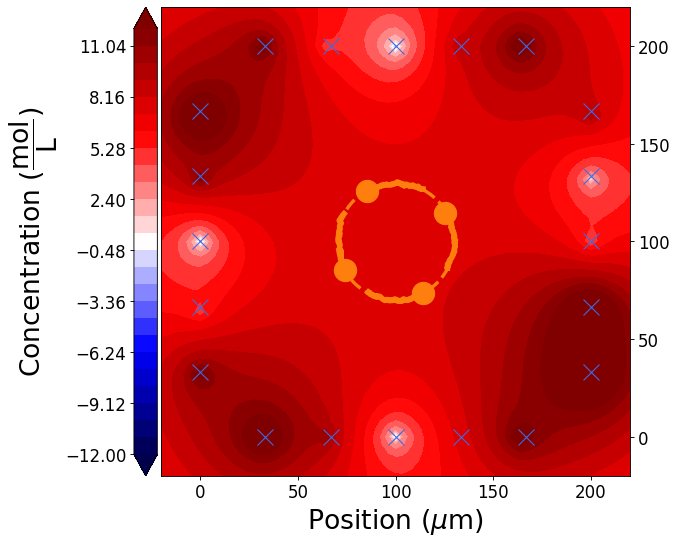

595 10
[ 1.42304443e+01 -1.52199037e+00 -4.79873803e+00  8.42314514e+00
  3.38102797e+00  1.06609861e+01  1.54714615e+01 -1.46570612e+00
  1.01212350e-02 -2.55044329e-01  3.54376111e-02 -2.67117750e-01
 -2.49383767e-02  8.97660280e-02  4.93625454e-01 -2.17634670e-02
 -4.76862821e-02  2.16084737e-01  3.35603254e-02  7.91167454e-02
 -8.71074623e-02 -1.10465062e-01 -2.72598085e-01  7.79164888e-02
 -1.20432532e-01 -2.80216342e-01  1.28216573e-01  1.21063216e-01
  2.41149660e-01 -9.34896732e-02  1.09209676e-02  1.03353928e-01
 -1.86143744e-01 -1.30070408e-01  1.78604602e-01  2.05736984e-01
  1.31519184e-01 -1.88246311e-01 -2.99104201e-01  2.10744714e-01
 -5.43885449e-01 -1.04365249e+00  5.44049697e-01  1.02735335e+00
  1.05211966e+00 -5.47927413e-01 -9.93545504e-01  5.31348302e-01]
[ 1.49514451  1.27163288  1.27011408  1.01479667  0.85141774  2.63417572
  2.39230737  2.71794522  2.47499877  2.2341488   2.20259425  2.60745974
  2.5913099   2.55619549  2.1893536   1.56749282  1.24679417  1.29

In [23]:
##run simulation and controller
xy = np.zeros((ntimes,2,nparticles))
xy[0] = pos.T
vxy = np.zeros((ntimes,2,nparticles))
##vxy[0] is zero
if mode == "electric":
    uguess = np.zeros(nelectrodes*(nvision+1))
elif mode == "chemical":
    uguess = np.zeros(nprobes*nvision)
ustore = np.zeros((ntimes,nprobes))
ustoreelec = np.zeros((ntimes,nelectrodes))
grid = np.zeros((nxy,nxy))     # solution array. This is a duplicate
mupred = np.ones(ntimes)*muguess
Dpred = np.ones(ntimes)*Dguess

for i in range(ntimes-nvision): 
    if i == 0: #this is sort of a janky fix to make array sizes work 
        result = least_squares(objective,uguess, bounds = bnds, args = (tsteps[:i+nvision],np.zeros((nprobes,0)), xy[i],i,mode))
    elif i < ncutoffsteps: 
        if i > npast: #implement MHE when this is true. Implemented for chem, but not yet for elec. 
            startMHE = i-npast
            measuredpos = xy[startMHE:i+1]  
            MHEresult = least_squares(objectiveMHE,np.array([mupred[i-1],Dpred[i-1]]),bounds = mhebnds,args = (np.array([mupred[i-1],Dpred[i-1]]),ustore[:i].T,ustoreelec[:i].T,measuredpos,startMHE))
            mupred[i],Dpred[i] = MHEresult.x #if this works, then use mupred and Dpred in the MPC part.
        result = least_squares(objective,uguess, bounds = bnds, args = (tsteps[:i+nvision],ustore[:i].T, xy[i],i,mode))
    else:
        if i > npast: #implement MHE when this is true. Implemented for chem, then get elec working
            startMHE = i-npast
            measuredpos = xy[startMHE:i+1]  
            MHEresult = least_squares(objectiveMHE,np.array([mupred[i-1],Dpred[i-1]]),bounds = mhebnds,args = (np.array([mupred[i-1],Dpred[i-1]]),ustore[i-ncutoffsteps:i].T,ustoreelec[i-ncutoffsteps:i].T,measuredpos,startMHE))
            mupred[i],Dpred[i] = MHEresult.x #if this works, then use mupred and Dpred in the MPC part.
        result = least_squares(objective,uguess, bounds = bnds, args = (tsteps[i-ncutoffsteps:i+nvision],ustore[i-ncutoffsteps:i].T, xy[i],i,mode))
    uresult = result.x #this gives the input divided by uemax. 
    if mode == "chemical":
        uresult = np.reshape(uresult,(nprobes,-1))   #nvision? 
        uresultelec = np.zeros((nelectrodes,nvision)) #maybe simplify this
    elif mode == "electric":
        uresultelec = np.reshape(uresult,(nelectrodes,-1))
        uresult = np.zeros((nprobes,nvision))
    
    xy[i+1] = process(uresult[:,0],uresultelec[:,0],grid,tlarge[i*dtratio:(i+1)*dtratio],xy[i])
    ustore[i] = uresult[:,0]
    ustoreelec[i] = uresultelec[:,0]
    plotit(i+1,xy[:,0],xy[:,1])
    savedata(i)
    print(i, result.nfev)
    print(result.fun[:(nvision+1)*nparticles*2])
    print(result.fun[(nvision+1)*nparticles*2:])
    

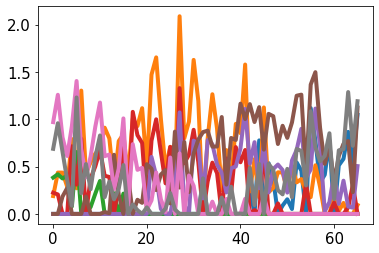

In [20]:
plt.plot(t[:i],ustoreelec[:i]/uemax, lw = 4)
#plt.legend(["West","East","South","North"], loc = 1)

Text(0, 0.5, '||u||')

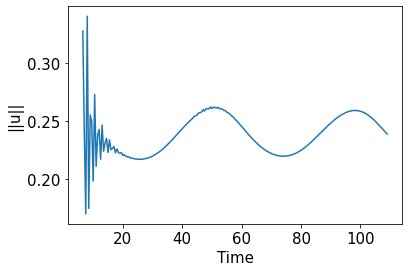

In [14]:
tim = np.zeros(i)
yew = np.zeros(i)
for k in range(i):
    tim[k] = t[k+1]
    yew[k] = np.linalg.norm(ustore[k]/umax)#/vaveragearray[k]
plt.plot(tim[12:],yew[12:])
# plt.axvline(np.pi/2*rd/v0,color = "r")
# plt.axvline(np.pi*rd/v0,color = "r")
plt.xlabel("Time")
plt.ylabel("||u||")

In [230]:
thing1 = objectiveMHE(MHEresult.x,np.array([mupred[i-1],Dpred[i-1]]),ustore[:i].T,ustoreelec[:i].T,measuredpos,startMHE)
print(sum(thing1**2))
thing2 = objectiveMHE(np.array([mu,D]), np.array([mupred[i-1],Dpred[i-1]]),ustore[:i].T,ustoreelec[:i].T,measuredpos,startMHE)
print(sum(thing2**2))

31.23823689447781
0.0198241567301649


In [15]:
index = 3
spacing = int(index*(nxy-1)/(boundaryscale*(nprobes/4+1)))
print(index*(nxy-1)/(boundaryscale*(nprobes/4+1)))
print(spacing)

25.0
25


1